# Manual dataset exploration using spark with normalDate as timestamp

### Import of the various libraries used

In [1]:
import warnings

import pandas as pd
import json
import requests, os, sys
import numpy as np
from datetime import datetime
import re
import pickle
import matplotlib.pyplot as plt
import collections

import pyspark
from pyspark.sql.types import IntegerType, StringType, DoubleType, TimestampType, StructType, StructField

if sys.version_info.major == 3:
    from io import StringIO
else:
    from StringIO import StringIO

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

%matplotlib inline

### Create a spark session

In [2]:
spark = (pyspark.sql.SparkSession
    .builder
    .config('spark.master', 'local[*]')
    .config('spark.driver.cores', '4')
    .config('spark.executor.memory', '2g')
    .config('spark.driver.memory', '6g')
    .getOrCreate())

### Misc functions used

In [3]:
def date_format(matched):
    return (matched.group()[0:3] + '.' + matched.group().replace(".", "")[3:-1] + '0' * (11 - len(matched.group())))[0:10]

def open_dataframe_pickle(name_of_pickle):
    with open(name_of_pickle, 'rb') as f:
        df_from_pickle = pickle.load(f)
    return df_from_pickle

def save_dataframe_as_pickle(frame_to_save, save_name):
    with open(save_name, 'wb') as f:
        pickle.dump(frame_to_save, f)
    return

### Import data

In [4]:
# load data and concat into a single dataframe
path_root = './data_DFd_V3'
files = os.listdir(path_root)
print('importing file: ', files[0],' | ', 1, ' of ', len(files))
df_all = open_dataframe_pickle(os.path.join(path_root, files[0]))
for i in range(1, len(files)):
    print('importing file: ', files[i],' | ', i+1, ' of ', len(files))
    temp_df = open_dataframe_pickle(os.path.join(path_root, files[i]))
    df_all = pd.concat([df_all, temp_df], axis=0, join='inner', join_axes=None, ignore_index=False,
                       verify_integrity=False)
# find duplicates
duplicates = df_all[df_all.duplicated(keep=False)]
# remove duplicates from dataset
df_all.drop_duplicates(keep='first', inplace=True)
df_all.sort_values('normalDate', inplace=True)

importing file:  10.0.40.2_0e739f4a-e714-425e-abe7-8b41721287b1_all_data_as_df_v3.pickle  |  1  of  24
importing file:  10.0.40.1_bfc3138a-1c45-41aa-a1df-9e9e573b9cfe_all_data_as_df_v3.pickle  |  2  of  24
importing file:  10.0.40.2_bbc6e2a3-bb94-4497-89af-da7f79cde130_all_data_as_df_v3.pickle  |  3  of  24
importing file:  10.0.40.1_d902c04f-4511-48f1-997f-81930441ad4e_all_data_as_df_v3.pickle  |  4  of  24
importing file:  10.0.40.3_bbc6e2a3-bb94-4497-89af-da7f79cde130_all_data_as_df_v3.pickle  |  5  of  24
importing file:  10.0.40.3_d902c04f-4511-48f1-997f-81930441ad4e_all_data_as_df_v3.pickle  |  6  of  24
importing file:  10.0.40.3_f9452b13-8dd8-4252-96ea-c80e24d8006a_all_data_as_df_v3.pickle  |  7  of  24
importing file:  10.0.40.2_42e64704-015e-4c5a-a0d3-35bb228db837_all_data_as_df_v3.pickle  |  8  of  24
importing file:  10.0.40.1_0e739f4a-e714-425e-abe7-8b41721287b1_all_data_as_df_v3.pickle  |  9  of  24
importing file:  10.0.40.1_42e64704-015e-4c5a-a0d3-35bb228db837_all_data_

### Explicitly define the schema for the spark dataframe and create spark dataframe

In [5]:
schema = StructType([
    StructField('bytesIn', DoubleType(), True),
    StructField('bytesInOut', DoubleType(), True),
    StructField('bytesOut', DoubleType(), True),
    StructField('commonEventId', IntegerType(), True),
    StructField('count',  IntegerType(), True),
    StructField('direction', IntegerType(), True),
    StructField('duration', DoubleType(), True), 
    StructField('entityId', IntegerType(), True), 
    StructField('file',  StringType(), True),
    StructField('impactedEntityId', DoubleType(), True),
    StructField('impactedHostId', DoubleType(), True),
    StructField('impactedHostTotalPackets', DoubleType(), True),
    StructField('impactedInterface', StringType(), True),
    StructField('impactedIp', StringType(), True),
    StructField('impactedNatPort', DoubleType(), True),
    StructField('impactedNetworkId', DoubleType(), True),
    StructField('impactedPort', DoubleType(), True),
    StructField('impactedZoneEnum', IntegerType(), True),
    StructField('indexId', StringType(), True),
    StructField('isEvent', StringType(), True),
    StructField('itemsPacketsIn', DoubleType(), True),
    StructField('logSequence', IntegerType(), True),
    StructField('logSourceId', IntegerType(), True),
    StructField('login', StringType(), True),
    StructField('msgClassId', IntegerType(), True),
    StructField('msgSourceTypeId', IntegerType(), True),
    StructField('node', StringType(), True),
    StructField('normalDate', StringType(), True),
    StructField('originEntityId', DoubleType(), True),
    StructField('originHostId', DoubleType(), True),
    StructField('originInterface', StringType(), True),
    StructField('originIp', StringType(), True),
    StructField('originNatPort', DoubleType(), True),
    StructField('originNetworkId', DoubleType(), True),
    StructField('originPort', DoubleType(), True),
    StructField('originZoneEnum', StringType(), True),
    StructField('processId', DoubleType(), True),
    StructField('protocolId', DoubleType(), True),
    StructField('quantity', DoubleType(), True),
    StructField('rootEntityId', IntegerType(), True),
    StructField('serviceId', DoubleType(), True),
    StructField('session', StringType(), True),
    StructField('size', DoubleType(), True),
    StructField('vendorMessageId', StringType(), True),
    StructField('version', StringType(), True)]) 
sdf = spark.createDataFrame(data=df_all, schema=schema)
sdf = sdf.withColumn('timestamp',sdf['normalDate'].cast(TimestampType()))

### Make SQL table view of spark dataframe and create pandas dataframe from GROUP BY hour with SUM of bytesOut for visualization

In [6]:
sdf.createOrReplaceTempView('data')

In [7]:
# spark.sql("SELECT MONTH(timestamp), DAY(timestamp), HOUR(timestamp), SUM(bytesOut) \
#                 FROM data \
#                 WHERE cast(bytesOut as String) !='NaN' \
#                 GROUP BY YEAR(timestamp), MONTH(timestamp), DAY(timestamp), HOUR(timestamp) \
#                 ORDER BY YEAR(timestamp), MONTH(timestamp), DAY(timestamp), HOUR(timestamp)").show(10)

pdf_of_bytesOut_In_gr_by_hour = spark.sql("SELECT YEAR(timestamp) as year, MONTH(timestamp) as month, DAY(timestamp) as day, HOUR(timestamp) as hour, SUM(bytesOut) as total_bytesOut, SUM(bytesIn) as total_bytesIn \
                FROM data \
                WHERE cast(bytesOut as String) !='NaN' \
                GROUP BY YEAR(timestamp), MONTH(timestamp), DAY(timestamp), HOUR(timestamp) \
                ORDER BY YEAR(timestamp), MONTH(timestamp), DAY(timestamp), HOUR(timestamp)").toPandas()

time_index = list(zip(pdf_of_bytesOut_In_gr_by_hour['year'], 
                   pdf_of_bytesOut_In_gr_by_hour['month'],
                   pdf_of_bytesOut_In_gr_by_hour['day'], 
                   pdf_of_bytesOut_In_gr_by_hour['hour']))
pdf_of_bytesOut_In_gr_by_hour['timestamp'] = ([datetime(year=current[0], month=current[1], day=current[2], hour=current[3]) for current in time_index])

# pdf_of_bytesOut_In_gr_by_hour['timestamp'] = [datetime(x) for x in time_index]
pdf_of_bytesOut_In_gr_by_hour[['timestamp', 'total_bytesOut', 'total_bytesIn']].head(20)

,timestamp,total_bytesOut,total_bytesIn
0,2016-06-08 15:00:00,8.762078e+08,89239132.0
1,2016-06-08 16:00:00,3.824188e+08,81035453.0
2,2016-06-08 17:00:00,4.809690e+08,75507132.0
3,2016-06-08 18:00:00,1.131884e+08,24828786.0
4,2016-06-08 19:00:00,3.472579e+08,97653335.0
5,2016-06-08 20:00:00,6.185616e+08,149429281.0
6,2016-06-08 21:00:00,2.629880e+08,37828419.0
7,2016-06-08 22:00:00,5.238922e+08,90568223.0
8,2016-06-08 23:00:00,2.071825e+09,71879219.0
9,2016-06-09 00:00:00,1.947638e+09,57048569.0


 ### What is the hour with the largest outbound flow of bytes?

In [8]:
date_of_greatest_bytesOut = spark.sql("SELECT YEAR(timestamp), MONTH(timestamp), DAY(timestamp), HOUR(timestamp), SUM(bytesOut) \
                FROM data \
                WHERE cast(bytesOut as String) !='NaN' \
                GROUP BY YEAR(timestamp), MONTH(timestamp), DAY(timestamp), HOUR(timestamp) \
                ORDER BY sum(bytesOut) DESC").collect()[0].asDict()

(print('Peak outbound data flow grouped by hour is: ', date_of_greatest_bytesOut['month(CAST(timestamp AS DATE))'],'/', 
       date_of_greatest_bytesOut['dayofmonth(CAST(timestamp AS DATE))'],'/', 
       date_of_greatest_bytesOut['year(CAST(timestamp AS DATE))'],' between', 
       date_of_greatest_bytesOut['hour(timestamp)'], 'and', 
       date_of_greatest_bytesOut['hour(timestamp)']+1,' hours'))

Peak outbound data flow grouped by hour is:  6 / 10 / 2016  between 22 and 23  hours


### Visualization of data flow across network as individual events.

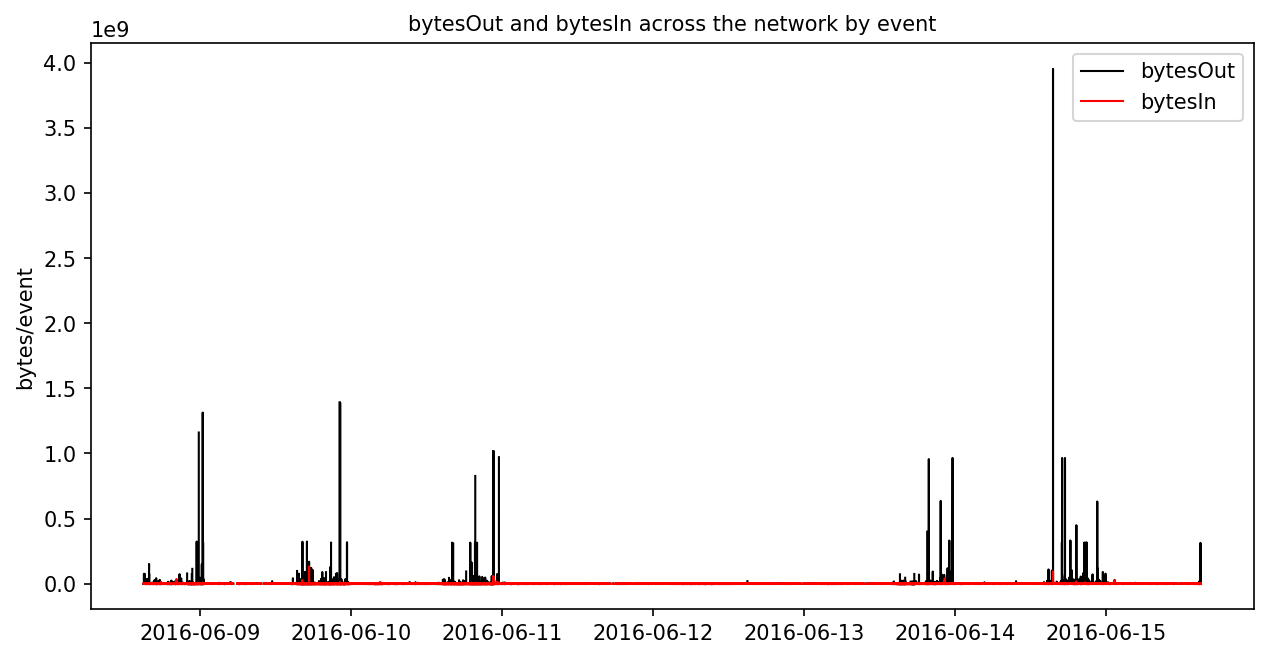

In [10]:
y_out = sdf.select('bytesOut').collect()
y_in = sdf.select('bytesIn').collect()
x = sdf.select('timestamp').collect()

fig, ax = plt.subplots(figsize=(10, 5), dpi=150, facecolor='w', edgecolor='k')
ax.plot(x, y_out, color='k', linewidth=1, label='bytesOut')
ax.plot(x, y_in, color='r', linewidth=1, label='bytesIn')
ax.set_ylabel('bytes/event', fontsize=10)
ax.set_title('bytesOut and bytesIn across the network by event', fontsize=10)
legend = ax.legend(loc='upper right')
plt.show()
plt.clf()

### Visualization of data flow across network when summed over hour-long windows. Clear outbound peak on 6/10/2016 between 22:00 at 23:00 hours.  You can also see that there is a temporally correlated inbound peak with the outbound peak.  Both of their magnitudes are suggestive anomalies.

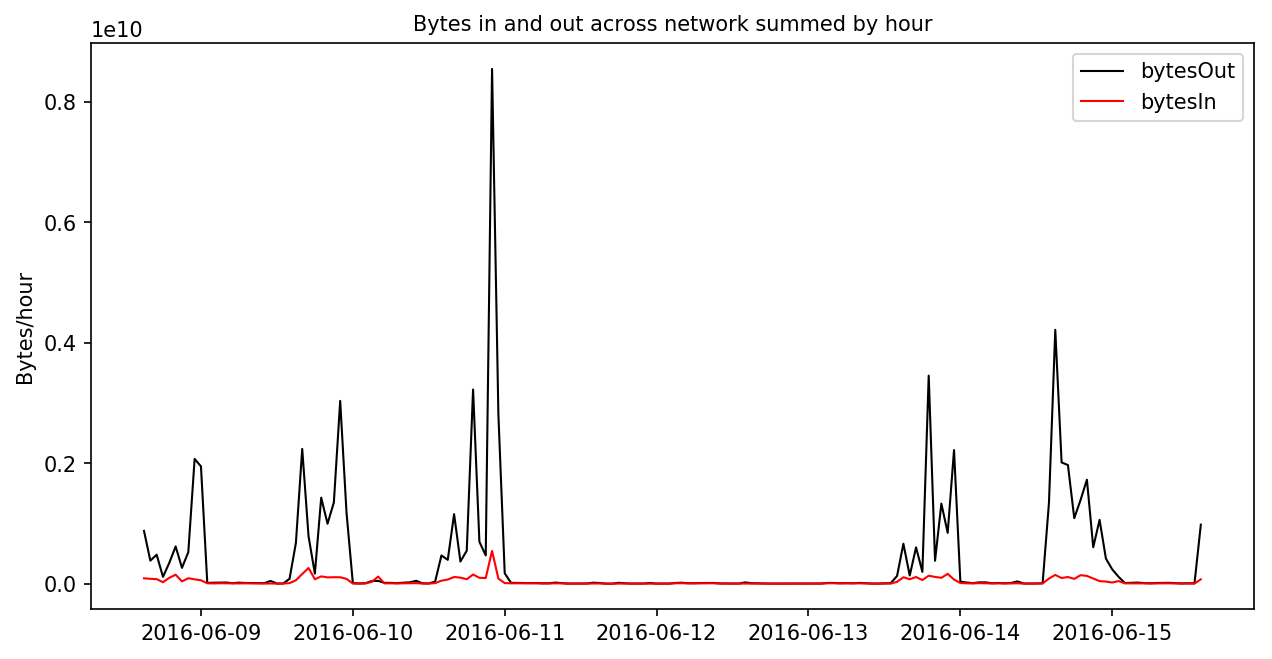

In [11]:
# y_out = list(pdf_of_bytesOut_In_gr_by_hour['total_bytesOut'])
# y_in = list(pdf_of_bytesOut_In_gr_by_hour['total_bytesIn'])
# x = list(pdf_of_bytesOut_In_gr_by_hour['timestamp'])

y_out = pdf_of_bytesOut_In_gr_by_hour['total_bytesOut']
y_in = pdf_of_bytesOut_In_gr_by_hour['total_bytesIn']
x = pdf_of_bytesOut_In_gr_by_hour['timestamp']

fig, ax = plt.subplots(figsize=(10, 5), dpi=150, facecolor='w', edgecolor='k')
ax.plot(x, y_out, color='k', linewidth=1, label='bytesOut')
ax.plot(x, y_in, color='r', linewidth=1, label='bytesIn')
ax.set_ylabel('Bytes/hour', fontsize=10)
ax.set_title('Bytes in and out across network summed by hour', fontsize=10)
legend = ax.legend(loc='upper right')
plt.show()
plt.clf()

### How many discrete feature types are there across the feature space during this critical hour? (ie: how many people logged in during this hour, how many IPs showed activity during this hour, etc)

In [13]:
subset_1 = 'entityId, impactedEntityId, impactedHostId, impactedInterface, impactedIp, impactedNatPort, \
impactedNetworkId, impactedPort, impactedZoneEnum, indexId, logSequence, logSourceId, login, msgClassId, \
msgSourceTypeId, originEntityId, originHostId, originInterface, originIp, originNatPort, originNetworkId, \
originPort, originZoneEnum, processId, protocolId, rootEntityId, serviceId, session, vendorMessageId'

interesting_groupings = collections.defaultdict()

for current in subset_1.split(', '):
    interesting_groupings[current] = spark.sql("SELECT DISTINCT " + current + " \
                                              FROM data \
                                              WHERE (YEAR(timestamp) =2016) \
                                                  AND (MONTH(timestamp) = 6) \
                                                  AND (DAY(timestamp) = 10) \
                                                  AND (HOUR(timestamp) = 22)").collect()
    
# interesting_groupings[current] = spark.sql("SELECT DISTINCT " + current + " \
#                                               FROM data \
#                                               WHERE (YEAR(timestamp) =2016) \
#                                                   AND (MONTH(timestamp) = 6) \
#                                                   AND (DAY(timestamp) = 10) \
#                                                   AND (HOUR(timestamp) = 22) \
#                                                   AND (" + current + " != 'nan')").collect()

In [14]:
for current in subset_1.split(', '):
    interesting_groupings[current]=[interesting_groupings[current][x][current] for x in range(len(interesting_groupings[current]))]
    print('number of unique identities (grouped by:', current, ').num of entries: ', len(interesting_groupings[current]))

number of unique identities (grouped by: entityId ).num of entries:  5
number of unique identities (grouped by: impactedEntityId ).num of entries:  8
number of unique identities (grouped by: impactedHostId ).num of entries:  15
number of unique identities (grouped by: impactedInterface ).num of entries:  2
number of unique identities (grouped by: impactedIp ).num of entries:  29
number of unique identities (grouped by: impactedNatPort ).num of entries:  2
number of unique identities (grouped by: impactedNetworkId ).num of entries:  3
number of unique identities (grouped by: impactedPort ).num of entries:  3955
number of unique identities (grouped by: impactedZoneEnum ).num of entries:  3
number of unique identities (grouped by: indexId ).num of entries:  35237
number of unique identities (grouped by: logSequence ).num of entries:  35062
number of unique identities (grouped by: logSourceId ).num of entries:  19
number of unique identities (grouped by: login ).num of entries:  19
number 

In [16]:
singular_features = ['impactedInterface',
                    'impactedNatPort',
                    'originInterface',
                    'originZoneEnum', 
                    'rootEntityId']
print('Singular features')
for current in singular_features:
    print('number of unique identities (grouped by:', current, ').num of entries: ', interesting_groupings[current])

Singular features
number of unique identities (grouped by: impactedInterface ).num of entries:  ['NaN', 'ethernet1/1']
number of unique identities (grouped by: impactedNatPort ).num of entries:  [nan, 80.0]
number of unique identities (grouped by: originInterface ).num of entries:  ['ethernet1/4', 'NaN']
number of unique identities (grouped by: originZoneEnum ).num of entries:  ['0', '1']
number of unique identities (grouped by: rootEntityId ).num of entries:  [1]


In [18]:
too_many_features = ['impactedPort', 
                     'indexId', 
                     'logSequence', 
                     'originPort', 
                     'session']
print('Many features')
for current in too_many_features:
    print('number of unique identities (grouped by:', current, ').num of entries: ', interesting_groupings[current])

Many features
number of unique identities (grouped by: impactedPort ).num of entries:  [63867.0, 64323.0, 49202.0, 51013.0, 51300.0, 52827.0, 59269.0, 60730.0, 60810.0, 62461.0, 64193.0, 64409.0, 64417.0, 60783.0, 58648.0, 62367.0, 62463.0, 63158.0, 64396.0, 64510.0, 64950.0, 65324.0, 65520.0, 49587.0, 49667.0, 49895.0, 60179.0, 50239.0, 50993.0, 60387.0, 60528.0, 60962.0, 61507.0, 61547.0, 62328.0, 62340.0, 63989.0, 60872.0, 61730.0, 62141.0, 62349.0, 63394.0, 62903.0, 63236.0, 63567.0, 64203.0, 64582.0, 60200.0, 52656.0, 59028.0, 62372.0, 62581.0, 62685.0, 62717.0, 64449.0, 57971.0, 62515.0, 63627.0, 63951.0, 64179.0, 49595.0, 49867.0, 50115.0, 50644.0, 51325.0, 58734.0, 61234.0, 62457.0, 64241.0, 60911.0, 61163.0, 61249.0, 61424.0, 63186.0, 63496.0, 62955.0, 49751.0, 50207.0, 50223.0, 51057.0, 51204.0, 52394.0, 52891.0, 53071.0, 58626.0, 59096.0, 59585.0, 59936.0, 64025.0, 64141.0, 51696.0, 61649.0, 62178.0, 62920.0, 62546.0, 62707.0, 63591.0, 63771.0, 64437.0, 64726.0, 64834.0, 649

### Show values for singular features and counts for unique features within each field during the critical hour.  Also, engineer some extra features such as mean packet size and mean packet delivery rate.  While these two engineered metrics may not be accurate as there is plenty of missing data, they may be still indicative of odd network behavior.

In [52]:



subset_2 = (['entityId',
             'impactedEntityId',
             'impactedHostId',
             'impactedIp',
             'impactedNetworkId',
             'impactedZoneEnum',
             'logSourceId',
             'login',
             'msgClassId',
             'msgSourceTypeId',
             'originEntityId',
             'originHostId',
             'originIp',
             'originNatPort',
             'originNetworkId',
             'originZoneEnum',
             'processId',
             'protocolId',
             'serviceId',
             'vendorMessageId'])

print('SINGULAR FEATURES')
for current in singular_features:
    print('Values of ',current, ': ', interesting_groupings[current])

SINGULAR FEATURES
Values of  impactedInterface :  ['NaN', 'ethernet1/1']


KeyError: 'impactedNatPort'

In [39]:
spark.stop()